# **Лабораторна робота №2**
### з дисципліни **"Інтелектуальні системи підтримки прийняття рішень"**

##### **За темою:** "Реалізація багатошарового персептрона для класифікації зображень MNIST в Python з нуля засобами Numpy. Алгоритм back propagation."

##### **Варіант:** 17

##### **Виконав:** Гавлицький Іван, КА-12

##### **Перевірила:** Недашкiвська Н.I.

### **Мета роботи:**
- Створити багатошарову нейронну мережу прямого розповсюдження сигналу за допомогою бiблiотеки *Numpy Python*.
- Реалiзувати власний клас, який наслiдує клас *object*.
- Реалiзувати алгоритм зворотного розповсюдження помилки (*back propagation*). Налаштувати ваги нейронної мережi.
- Використати багатошарову нейронну мережу прямого розповсюдження для класифiкацiї зображень типу *MNIST*.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### **Хід виконання роботи:**
Написати програму, яка реалiзує алгоритм градiєнтного спуску:
1. Завантажити простий набiр зображень згiдно з варiантом.
2. Виконати пiдготовку даних для навчання - за необхiдностi, залежно вiд вхiдного набору. Наприклад, нормалiзувати данi тощо.
3. За необхiдностi розбити данi на навчальну i перевiрочну множини у спiввiдношеннi 80%: 20%. Звернути увагу, що завантаженi данi вже можуть бути розбитi на навчальну i перевiрочну множини.
4. Побудувати базову мережу прямого розповсюдження сигналу з єдиним скритим шаром i output шаром *softmax*. Для створення моделi реалiзувати власний клас, який наслiдує клас *object*. Ваги iнiцiалiзувати невеликими випадковими значеннями, якi нормально розподiленi з нульовим середнiм та малою дисперсiєю.
5. Реалiзувати алгоритм зворотного розповсюдження помилки (*back propagation*).
6. Функцiєю втрат задати перехресну ентропiю.
7. Налаштувати ваги побудованої мережi реалiзованим алгоритмом *back propagation*.
8. Побудувати кiлька альтернативних мереж *MLP* з кiлькома скритими шарами *ReLU* або *tanh*. Налаштувати їх ваги реалiзованим алгоритмом *back propagation*.
9. Для кожної моделi побудувати:
- графiки змiни значень функцiї втрат на тренувальнiй i перевiрочнiй множинах по мiрi навчання моделi, тобто залежно вiд кiлькостi епох,
- графiки змiни показника accuracy на тренувальнiй i перевiрочнiй множинах по мiрi навчання моделi.
10. Пiдiбрати значення гiперпараметра швидкостi навчання.
11. Обрати для нейронiв скритих шарiв рiзнi функцiї активацiї: *LeakyReLU*, *Parametric LeakyReLU*, *ELU*. Спробувати з’ясувати чи впливає вибiр функцiї активацiї на:
- час навчання мережi,
- якiсть роботи мережi (фiнальне значення accuracy) на перевiрочнiй множинi,
- час надання прогнозу мережею.
12. Вiдобразити кiлька зображень, невiрно класифiкованих моделлю.

### **Data Loading**

In [2]:
data = pd.read_csv('/kaggle/input/clothing-dataset-full/images.csv')
data = data[data['label'] != 'Skip'].copy()

data

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False
...,...,...,...,...
5398,dfd4079d-967b-4b3e-8574-fbac11b58103,204,Shorts,False
5399,befa14be-8140-4faf-8061-1039947e329d,204,Body,True
5400,5379356a-40ee-4890-b416-2336a7d84061,310,Shorts,False
5401,65507fb8-3456-4c15-b53e-d1b03bf71a59,204,Shoes,False


In [3]:
from PIL import Image

images = []
labels = []

target_size = (28, 28)
for iii, row in data.iterrows():
    img_path = f"/kaggle/input/clothing-dataset-full/images_compressed/{row['image']}.jpg"
    img = Image.open(img_path).convert('L')
    
    img = img.resize(target_size) 
    img_array = np.array(img) / 255.0  
    images.append(img_array)
    labels.append(row['label'])
    
images = np.array(images)
labels = np.array(labels)


### **TrainTest Split and Data Preprocessing**

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f'Train features shape: {X_train.shape}, target shape: {y_train.shape}')
print(f'Test features shape: {X_test.shape}, target shape: {y_test.shape}')

Train features shape: (4312, 28, 28), target shape: (4312,)
Test features shape: (1079, 28, 28), target shape: (1079,)


In [5]:
def plot_images(img, labels, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols, constrained_layout=True)
    
    for ii, ax in enumerate(axes.flat): 
        ax.imshow(img[ii])
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.set_title(labels[ii])

Трохи картинок

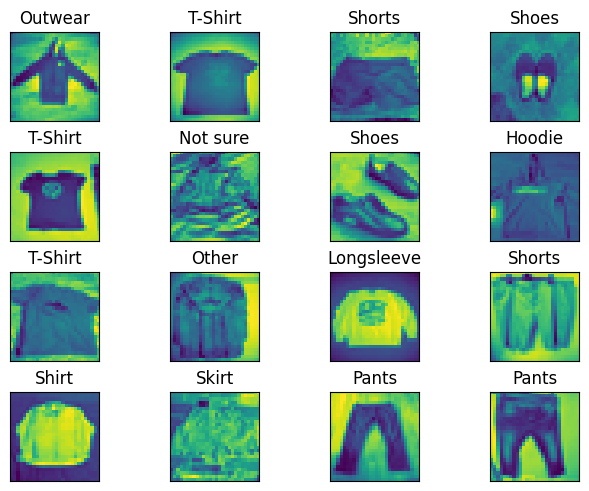

In [6]:
plot_images(X_train, y_train, 4, 4)

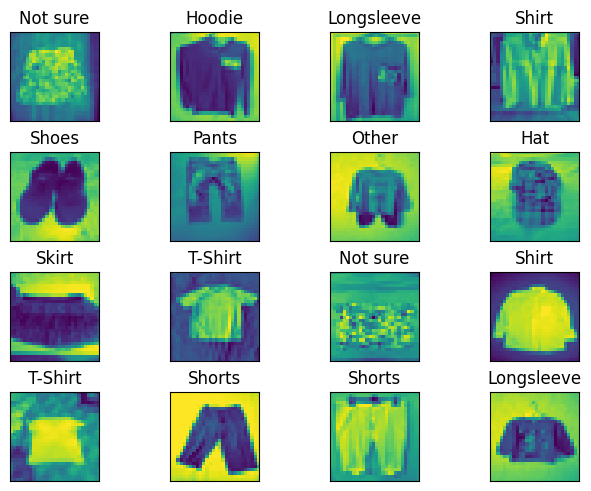

In [7]:
plot_images(X_test, y_test, 4, 4)

Перетворюємо розмірності вхідних даних

In [8]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print(f'Train features shape: {X_train.shape}')
print(f'Test features shape: {X_test.shape}')

Train features shape: (4312, 784)
Test features shape: (1079, 784)


Нормалізація

In [9]:
train_mean = np.mean(X_train, axis=0)
train_std = np.std(X_train, axis=0)

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean)  / train_std

Target Encoding

In [10]:
from sklearn.preprocessing import OneHotEncoder

target_encoder = OneHotEncoder(sparse_output=False)
y_train = target_encoder.fit_transform(y_train.reshape(-1, 1))
y_test = target_encoder.transform(y_test.reshape(-1, 1))

In [11]:
for ii, name in enumerate(target_encoder.get_feature_names_out()):
    print(f'Coord: {ii}, Label: {name[3:]}')

Coord: 0, Label: Blazer
Coord: 1, Label: Blouse
Coord: 2, Label: Body
Coord: 3, Label: Dress
Coord: 4, Label: Hat
Coord: 5, Label: Hoodie
Coord: 6, Label: Longsleeve
Coord: 7, Label: Not sure
Coord: 8, Label: Other
Coord: 9, Label: Outwear
Coord: 10, Label: Pants
Coord: 11, Label: Polo
Coord: 12, Label: Shirt
Coord: 13, Label: Shoes
Coord: 14, Label: Shorts
Coord: 15, Label: Skirt
Coord: 16, Label: T-Shirt
Coord: 17, Label: Top
Coord: 18, Label: Undershirt


### **Multilayer Perceptron**

In [12]:
class SimpleMLP(object):
    def __init__(
        self,
        n_hidden=30,
        l2=0.,
        epochs=100,
        eta=0.001,
        shuffle=True,
        minibatch_size=1,
        seed=None,
        activation='sigmoid',
        optimizer='sgd',
        beta1=0.9,
        beta2=0.999,
        epsilon=1e-8
        ):
        
        self.activation = activation
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        self.n_output = None
        self.optimizer = optimizer

        # Adam optimizer parameters
        self.m_h = 0 
        self.v_h = 0 
        self.m_out = 0 
        self.v_out = 0
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        
    def _activation_function(self, z):
        if self.activation == 'sigmoid':
            return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

        elif self.activation == 'relu':
            return np.maximum(0, np.clip(z, -250, 250))

        elif self.activation == 'tanh':
            return np.tanh(z)
        elif self.activation == 'elu':
            alpha = 1.0
            return np.where(z > 0, np.clip(z, -250, 250), alpha * (np.exp(np.clip(z, -250, 250)) - 1))

        elif self.activation == 'lrelu':
            alpha = 0.01
            return np.where(z > 0, np.clip(z, -250, 250), alpha * np.clip(z, -250, 250))

            
    def _activation_derivative(self, z):
        if self.activation == 'sigmoid':
            return self._activation_function(z) * (1. - self._activation_function(z))
        elif self.activation == 'relu':
            return np.where(z > 0, 1, 0)
        elif self.activation == 'tanh':
            return 1. - np.tanh(z)**2
        elif self.activation == 'elu':
            alpha = 1.0  # You can adjust the alpha parameter as needed
            return np.where(z > 0, 1, alpha * np.exp(np.clip(z, -250, 250)))
        elif self.activation == 'lrelu':
            alpha = 0.01  # You can adjust the alpha parameter as needed
            return np.where(z > 0, 1, alpha)
        
            
    def _forward(self, X):
        z_h = np.dot(X, self.w_h) + self.b_h
        a_h = self._activation_function(z_h)
#         print(f"f(X: {X.shape} * W: {self.w_h.shape} + b: {self.b_h.shape} = z: {z_h.shape}) = a: {a_h.shape}")

        z_out = np.dot(a_h, self.w_out) + self.b_out
        a_out = self._activation_function(z_out)
#         print(f"f(a: {a_h.shape} * W: {self.w_out.shape} + b: {self.b_out.shape} = z: {z_out.shape}) = a: {a_out.shape}")

        return z_h, a_h, z_out, a_out

    
    def _compute_cost(self, y_enc, output):
        L2_term = (self.l2 * (np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))

        term1 = -y_enc * np.log(np.clip(output, 1e-10, 1.0 - 1e-10))
        term2 = (1. - y_enc) * np.log(np.clip(1. - output, 1e-10, 1.0 - 1e-10))
        cost = np.sum(term1 - term2) + L2_term

        return cost

    
    def _initialize_weights(self, n_features):
        self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))
        self.w_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden, self.n_output))


    def _update_weights(self, grad_w_h, grad_b_h, grad_w_out, grad_b_out):
        if self.optimizer == 'sgd':
            # Stochastic Gradient Descent
            self.w_h -= self.eta * grad_w_h
            self.b_h -= self.eta * grad_b_h
            self.w_out -= self.eta * grad_w_out
            self.b_out -= self.eta * grad_b_out

        elif self.optimizer == 'adam':
            # Adam optimizer
            self.m_h = self.beta1 * self.m_h + (1 - self.beta1) * grad_w_h
            self.v_h = self.beta2 * self.v_h + (1 - self.beta2) * (grad_w_h ** 2)
            self.w_h -= self.eta * self.m_h / (np.sqrt(self.v_h) + self.epsilon)
            self.b_h -= self.eta * grad_b_h

            self.m_out = self.beta1 * self.m_out + (1 - self.beta1) * grad_w_out
            self.v_out = self.beta2 * self.v_out + (1 - self.beta2) * (grad_w_out ** 2)
            self.w_out -= self.eta * self.m_out / (np.sqrt(self.v_out) + self.epsilon)
            self.b_out -= self.eta * grad_b_out

        elif self.optimizer == 'rmsprop':
            # RMSprop
            self.v_h = self.beta2 * self.v_h + (1 - self.beta2) * (grad_w_h ** 2)
            self.w_h -= self.eta * grad_w_h / (np.sqrt(self.v_h) + self.epsilon)
            self.b_h -= self.eta * grad_b_h

            self.v_out = self.beta2 * self.v_out + (1 - self.beta2) * (grad_w_out ** 2)
            self.w_out -= self.eta * grad_w_out / (np.sqrt(self.v_out) + self.epsilon)
            self.b_out -= self.eta * grad_b_out
            

    def adjust_weight(self, delta, gradient, delta_min, delta_max):
        sign_gradient = np.sign(gradient)
        sign_delta = np.sign(delta)

        condition = np.logical_and(sign_gradient == sign_delta, gradient != 0)

        delta *= np.where(condition, self.eta_plus, self.eta_minus)
        delta = np.clip(delta, delta_min, delta_max)

        return delta

    def _accuracy(self, y_enc, output):
        predictions = np.argmax(output, axis=1)
        labels = np.argmax(y_enc, axis=1)

        accuracy = np.mean(predictions == labels)

        return accuracy
    
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        self.n_output = y_train.shape[1]
        n_features = X_train.shape[1]

        # Weight initialization
        self.b_h = np.zeros(self.n_hidden)
        self.b_out = np.zeros(self.n_output)

        self._initialize_weights(n_features)

        epoch_strlen = len(str(self.epochs))
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

#         y_train_enc = self._onehot(y_train, self.n_output)
        y_train_enc = y_train.copy()

        for i in range(self.epochs):

            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                # Backpropagation
                delta_out = a_out - y_train_enc[batch_idx]

                activation_derivative_h = self._activation_derivative(z_h)

                delta_h = (np.dot(delta_out, self.w_out.T) * activation_derivative_h)

                grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)

                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

                # Optimizer-specific updates
                self._update_weights(grad_w_h, grad_b_h, grad_w_out, grad_b_out)

            # Evaluation
            z_h, a_h, z_out, a_out = self._forward(X_train)

            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

#             train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float64) /
#                          X_train.shape[0])
#             valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float64) /
#                          X_valid.shape[0])
            train_acc = self._accuracy(y_train, y_train_pred)
            valid_acc = self._accuracy(y_valid, y_valid_pred)

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        print('\r%0*d/%d | Cost: %.2f '
                 '| Train / Test Accuracy: %.2f%%/%.2f%% ' %
                 (epoch_strlen, i+1, self.epochs, cost,
                  train_acc*100, valid_acc*100))
        return self

    
    def predict(self, X):
        z_h, a_h, z_out, a_out = self._forward(X)
        
        max_indices = np.argmax(z_out, axis=1)
        y_pred = np.zeros_like(z_out)
        y_pred[np.arange(y_pred.shape[0]), max_indices] = 1
        
        return y_pred

#### **Порівняємо моделі із різними функціями активації**

In [13]:
def plot_curves(estimator):
    y_test_pred = estimator.predict(X_test)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(range(1, len(estimator.eval_['cost']) + 1), estimator.eval_['cost'], label='Training Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Cost')
    ax1.set_title('Neural Network (ReLU) - Training Loss')
    ax1.legend()

    ax2.plot(range(1, len(estimator.eval_['train_acc']) + 1), estimator.eval_['train_acc'], label='Train')
    ax2.plot(range(1, len(estimator.eval_['valid_acc']) + 1), estimator.eval_['valid_acc'], label='Test')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Neural Network (ReLU) - Train and Test Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    test_acc = np.sum(y_test == y_test_pred) / len(y_test)

**ReLU**

In [14]:
nn_relu = SimpleMLP(
    n_hidden=50,
    epochs=50,
    eta=0.0001,
    minibatch_size=200,
    activation='relu',
    optimizer='rmsprop'
)


nn_relu.fit(X_train, y_train, X_test, y_test)

50/50 | Cost: 16474.59 | Train / Test Accuracy: 54.24%/39.48% 


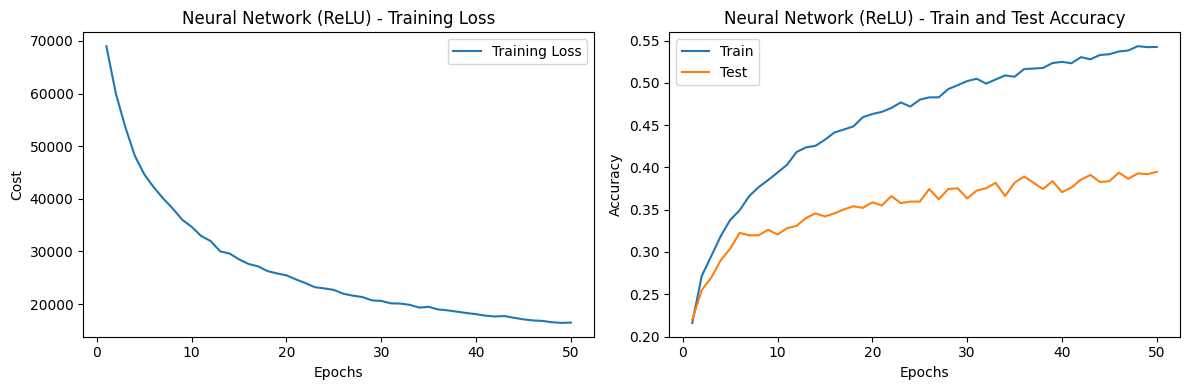

In [15]:
plot_curves(nn_relu)

**Tanh**

In [16]:
nn_tanh = SimpleMLP(
    n_hidden=50,
    epochs=50,
    eta=0.0001,
    minibatch_size=200,
    activation='tanh',
    optimizer='rmsprop'
)


nn_tanh.fit(X_train, y_train, X_test, y_test)

50/50 | Cost: 14685.82 | Train / Test Accuracy: 41.42%/35.59% 


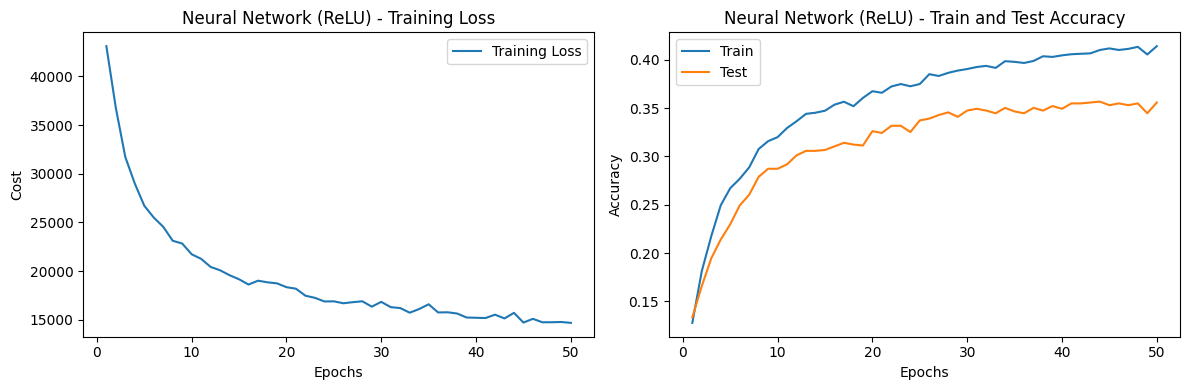

In [17]:
plot_curves(nn_tanh)

Бачимо, що ***MLP*** трохи зашивається на цьому датасеті, проте робота не про це. Тренування іде: функція втрат падає, accuracy росте при збільшенні кількості епох. 

In [18]:
from sklearn.metrics import accuracy_score
import time

epochs = 50

activation_functions = ['relu', 'sigmoid', 'tanh', 'elu', 'lrelu']

for activation_function in activation_functions:
    print(f"Activation: {activation_function}")

    nn = SimpleMLP(
        n_hidden=50,
        epochs=epochs,
        eta=0.0001,
        minibatch_size=200,
        activation=activation_function
    )

    t0 = time.time()
    nn.fit(X_train, y_train, X_test, y_test)
    t1 = time.time()

    print(f"Learning process: {int(t1 - t0)}s")

    t0_0 = time.time()
    y_train_pred = nn.predict(X_train)
    y_test_pred = nn.predict(X_test)
    t0_1 = time.time()

    print(f"Predicting process: {int(t0_1 - t0_0)}s")

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"Train accuracy: {train_accuracy * 100:.2f}%")
    print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Activation: relu
50/50 | Cost: 17031.94 | Train / Test Accuracy: 48.86%/39.76% 
Learning process: 2s
Predicting process: 0s
Train accuracy: 48.86%
Test accuracy: 39.76%
Activation: sigmoid
50/50 | Cost: 12955.99 | Train / Test Accuracy: 39.08%/36.42% 
Learning process: 3s
Predicting process: 0s
Train accuracy: 39.08%
Test accuracy: 36.42%
Activation: tanh
50/50 | Cost: 15146.10 | Train / Test Accuracy: 37.82%/34.57% 
Learning process: 4s
Predicting process: 0s
Train accuracy: 37.82%
Test accuracy: 34.57%
Activation: elu
50/50 | Cost: 14212.01 | Train / Test Accuracy: 41.37%/36.98% 
Learning process: 4s
Predicting process: 0s
Train accuracy: 41.37%
Test accuracy: 36.98%
Activation: lrelu
50/50 | Cost: 16664.73 | Train / Test Accuracy: 47.43%/39.11% 
Learning process: 3s
Predicting process: 0s
Train accuracy: 47.43%
Test accuracy: 39.11%


В нашому випадку зміна функції активації, не дала суттєвого впливу на точність. Проте, можна побачити явні відмінності у швидкості навчання:
- кращий результат: $5s$ у $ReLU$ та $LReLU$
- гірший результат: $12s$ у $Tanh$

Сумарно краще за всіх виступила $LReLU$.

Підберемо значення гіперпараметра швидкості навчання

In [19]:
l_rates = [0.00001, 0.0001, 1]
best_acc = 0
best_lrate = 0

for learning_rate in l_rates:
    print('learning rate=', learning_rate)
    nn = SimpleMLP(
        n_hidden=100,
        epochs=epochs,
        eta=learning_rate,
        minibatch_size=200,
        activation='lrelu'
    )
    nn.fit(X_train, y_train, X_test, y_test)
    y_test_pred = nn.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    if test_accuracy > best_acc:
        best_lrate = learning_rate
        best_acc = test_accuracy

print('\nBest learning rate =', best_lrate)

learning rate= 1e-05
50/50 | Cost: 45854.97 | Train / Test Accuracy: 32.75%/26.23% 
learning rate= 0.0001
50/50 | Cost: 14792.49 | Train / Test Accuracy: 56.96%/41.61% 
learning rate= 1
50/50 | Cost: 122221.22 | Train / Test Accuracy: 11.04%/12.33% 

Best learning rate = 0.0001


#### **Відобразимо помилки моделі**

50/50 | Cost: 15730.25 | Train / Test Accuracy: 53.73%/40.78% 


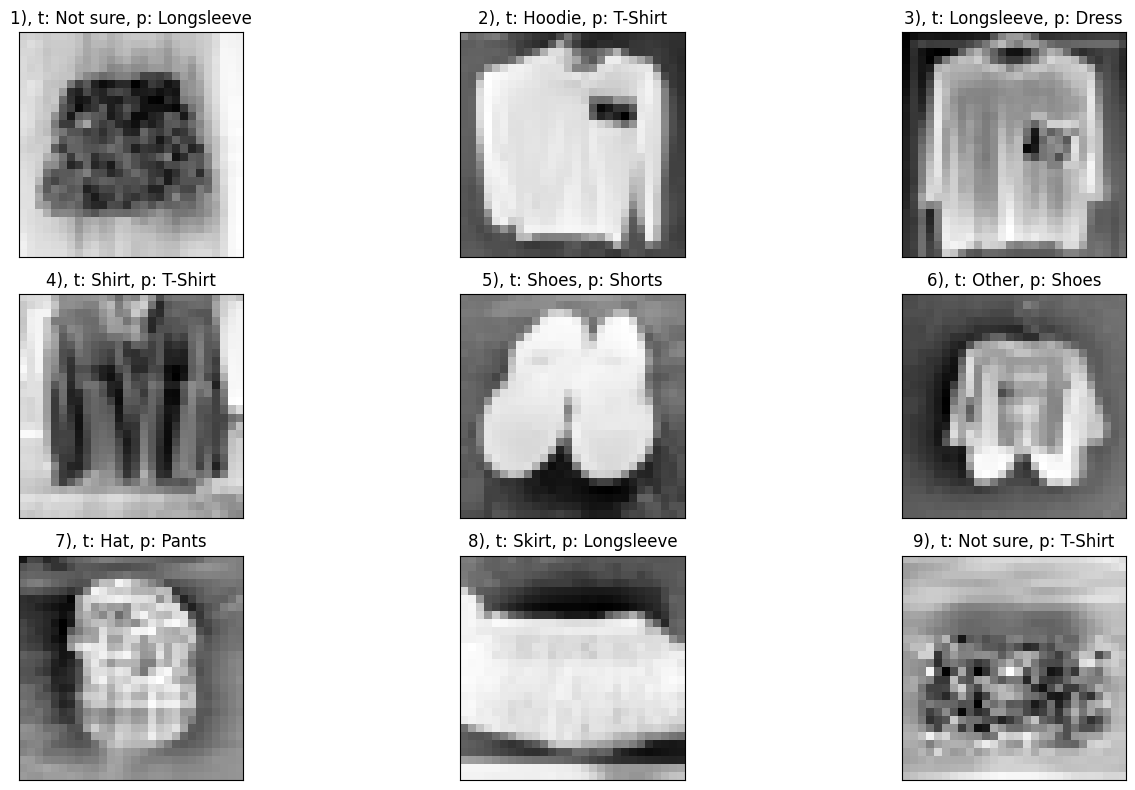

In [28]:
nn = SimpleMLP(
    n_hidden=50,
    epochs=50,
    eta=0.0001,
    minibatch_size=200,
    activation='lrelu',
    optimizer='rmsprop'
)

nn.fit(X_train, y_train, X_test, y_test)

y_test_pred = target_encoder.inverse_transform(nn.predict(X_test)).T[0]
labels_test = target_encoder.inverse_transform(y_test).T[0]
mask = (y_test_pred != labels_test)

wrong_x_test = X_test[mask][:25]
wrong_y_test = labels_test[mask][:25]
wrong_y_test_pred = y_test_pred[mask][:25]

fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(15, 8))
ax = ax.flatten()
for i in range(9):
    img = wrong_x_test[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}), t: {wrong_y_test[i]}, p: {wrong_y_test_pred[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()